# COBOL Requirements Extraction and Analysis

This notebook demonstrates how to extract business requirements from COBOL programs and store them in a vector database for intelligent search and analysis. 

## Project Overview
- **Goal**: Extract functional requirements from legacy COBOL programs
- **Approach**: Use NLP and vector embeddings for semantic analysis
- **Storage**: Vector database (Qdrant) for similarity search
- **Enhancement**: GitHub Copilot for intelligent code suggestions
- **No External LLMs**: Uses only local models and GitHub Copilot

## Prerequisites
1. Qdrant server running: `docker run -p 6333:6333 qdrant/qdrant`
2. GitHub Copilot extension enabled in VS Code
3. COBOL source files in text format

## Section 1: Setup Environment and Import Libraries

In [2]:
# Import necessary libraries for COBOL requirements extraction
import os
import re
import pandas as pd
import numpy as np
from pathlib import Path
from typing import List, Dict, Optional, Tuple
import datetime
import json

# Vector database and ML libraries
from qdrant_client import QdrantClient, models
from sentence_transformers import SentenceTransformer

# Text processing
import nltk
from collections import defaultdict, Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Import our custom COBOL extractor
from cobol_requirements_extractor import COBOLRequirementsExtractor

print("✅ All libraries imported successfully!")
print("💡 Tip: Use GitHub Copilot to suggest improvements to import statements")


✅ All libraries imported successfully!
💡 Tip: Use GitHub Copilot to suggest improvements to import statements
✅ All libraries imported successfully!
💡 Tip: Use GitHub Copilot to suggest improvements to import statements


## Section 2: Read COBOL Programs from Text Files

In [3]:
# Configuration for COBOL file processing
COBOL_EXTENSIONS = ['.cbl', '.cob', '.cobol', '.CBL', '.COB', '.txt']
ENCODING_OPTIONS = ['utf-8', 'cp1252', 'ascii', 'iso-8859-1']

def read_cobol_files_from_directory(directory_path: str) -> List[Dict]:
    """
    Read all COBOL files from a directory with proper encoding handling.
    GitHub Copilot: Suggest improvements for handling different encodings.
    """
    cobol_files = []
    directory = Path(directory_path)
    
    if not directory.exists():
        print(f"❌ Directory not found: {directory_path}")
        return []
    
    # Find all COBOL files
    for file_path in directory.rglob('*'):
        if file_path.is_file() and any(str(file_path).endswith(ext) for ext in COBOL_EXTENSIONS):
            file_info = read_single_cobol_file(str(file_path))
            if file_info:
                cobol_files.append(file_info)
    
    print(f"📁 Found {len(cobol_files)} COBOL files in {directory_path}")
    return cobol_files

def read_single_cobol_file(file_path: str) -> Optional[Dict]:
    """
    Read a single COBOL file with encoding detection.
    GitHub Copilot: Help improve encoding detection logic.
    """
    for encoding in ENCODING_OPTIONS:
        try:
            with open(file_path, 'r', encoding=encoding) as f:
                content = f.read()
            
            return {
                'file_path': file_path,
                'file_name': os.path.basename(file_path),
                'content': content,
                'encoding_used': encoding,
                'file_size': os.path.getsize(file_path),
                'lines_count': len(content.splitlines())
            }
        except UnicodeDecodeError:
            continue
        except Exception as e:
            print(f"⚠️ Error reading {file_path}: {e}")
            return None
    
    print(f"❌ Could not decode {file_path} with any encoding")
    return None

# Example: Create sample COBOL content for testing
sample_cobol_program = '''
      * SAMPLE CUSTOMER VALIDATION PROGRAM
      * THIS PROGRAM VALIDATES CUSTOMER DATA AND PROCESSES ORDERS
       IDENTIFICATION DIVISION.
       PROGRAM-ID. CUSTVAL.
       AUTHOR. SYSTEM ANALYST.
       DATE-WRITTEN. 01/15/2024.
      *
      * BUSINESS REQUIREMENTS:
      * 1. VALIDATE CUSTOMER ID FORMAT (MUST BE 6 DIGITS)
      * 2. CHECK CREDIT LIMIT BEFORE PROCESSING ORDER
      * 3. UPDATE CUSTOMER STATUS BASED ON PAYMENT HISTORY
      *
       ENVIRONMENT DIVISION.
       INPUT-OUTPUT SECTION.
       FILE-CONTROL.
           SELECT CUSTOMER-FILE ASSIGN TO "CUSTDATA.DAT"
           ORGANIZATION IS SEQUENTIAL.
       
       DATA DIVISION.
       FILE SECTION.
       FD CUSTOMER-FILE.
       01 CUSTOMER-RECORD.
          05 CUST-ID          PIC 9(6).
          05 CUST-NAME        PIC X(30).
          05 CREDIT-LIMIT     PIC 9(7)V99.
          05 CURRENT-BALANCE  PIC 9(7)V99.
          05 STATUS-CODE      PIC X(1).
       
       WORKING-STORAGE SECTION.
       01 WS-VALIDATION-FLAGS.
          05 VALID-CUSTOMER   PIC X(1) VALUE 'N'.
          05 CREDIT-OK        PIC X(1) VALUE 'N'.
       
       PROCEDURE DIVISION.
       MAIN-PROCESS.
           PERFORM VALIDATE-CUSTOMER-ID
           IF VALID-CUSTOMER = 'Y'
              PERFORM CHECK-CREDIT-LIMIT
              IF CREDIT-OK = 'Y'
                 PERFORM PROCESS-ORDER
              ELSE
                 DISPLAY 'CREDIT LIMIT EXCEEDED'
              END-IF
           ELSE
              DISPLAY 'INVALID CUSTOMER ID'
           END-IF.
           STOP RUN.
       
       VALIDATE-CUSTOMER-ID.
      * BUSINESS RULE: CUSTOMER ID MUST BE 6 DIGITS
           IF CUST-ID IS NUMERIC AND CUST-ID > 100000
              MOVE 'Y' TO VALID-CUSTOMER
           ELSE
              MOVE 'N' TO VALID-CUSTOMER
           END-IF.
'''

# Save sample for testing
with open('sample_customer_validation.cbl', 'w') as f:
    f.write(sample_cobol_program)

print("📝 Sample COBOL program created: sample_customer_validation.cbl")
print("💡 GitHub Copilot: Try asking for suggestions to improve file reading functions")

📝 Sample COBOL program created: sample_customer_validation.cbl
💡 GitHub Copilot: Try asking for suggestions to improve file reading functions


## Section 3: Initialize COBOL Requirements Extractor

In [4]:
# Initialize the COBOL Requirements Extractor
print("🔧 Initializing COBOL Requirements Extractor...")

# Check if Qdrant is running
try:
    extractor = COBOLRequirementsExtractor()
    print("✅ Connected to Qdrant vector database")
    print(f"📊 Collection: {extractor.collection_name}")
    print(f"🧠 Model: {extractor.model}")
except Exception as e:
    print(f"❌ Error connecting to Qdrant: {e}")
    print("💡 Make sure Qdrant is running: docker run -p 6333:6333 qdrant/qdrant")
    extractor = None

# Test the extractor with our sample file
if extractor:
    print("\n🧪 Testing with sample COBOL program...")
    try:
        result = extractor.extract_requirements_from_program('sample_customer_validation.cbl')
        print(f"✅ Extraction successful!")
        print(f"📋 Program ID: {result['program_id']}")
        print(f"📊 Requirements extracted: {result['requirements_extracted']}")
        print(f"📈 Data items found: {result['data_items_found']}")
        print(f"🔧 Procedures found: {result['procedures_found']}")
    except Exception as e:
        print(f"❌ Extraction failed: {e}")

print("\n💡 GitHub Copilot Tips:")
print("- Ask Copilot to suggest improvements to error handling")
print("- Request better connection retry logic")
print("- Get suggestions for additional extractor configurations")

🔧 Initializing COBOL Requirements Extractor...
❌ Error connecting to Qdrant: [WinError 10061] No connection could be made because the target machine actively refused it
💡 Make sure Qdrant is running: docker run -p 6333:6333 qdrant/qdrant

💡 GitHub Copilot Tips:
- Ask Copilot to suggest improvements to error handling
- Request better connection retry logic
- Get suggestions for additional extractor configurations
❌ Error connecting to Qdrant: [WinError 10061] No connection could be made because the target machine actively refused it
💡 Make sure Qdrant is running: docker run -p 6333:6333 qdrant/qdrant

💡 GitHub Copilot Tips:
- Ask Copilot to suggest improvements to error handling
- Request better connection retry logic
- Get suggestions for additional extractor configurations


## Section 4: Parse COBOL Code Structure and Extract Requirements

In [6]:
# Detailed analysis of the extracted COBOL program structure
if extractor:
    # Parse the sample program for detailed analysis
    program_info = extractor.parse_cobol_file('sample_customer_validation.cbl')
    
    print("📋 COBOL Program Analysis Results:")
    print("=" * 50)
    
    print(f"\n🏷️ Program ID: {program_info['program_id']}")
    print(f"📁 File: {program_info['file_name']}")
    
    print(f"\n📚 Divisions Found:")
    for div_name, div_content in program_info['divisions'].items():
        if div_content:
            print(f"  ✅ {div_name}: {len(div_content)} characters")
        else:
            print(f"  ❌ {div_name}: Not found")
    
    print(f"\n📊 Data Items ({len(program_info['data_items'])}):")
    for item in program_info['data_items'][:5]:  # Show first 5
        print(f"  📌 Level {item['level']}: {item['name']} - {item['picture']}")
    if len(program_info['data_items']) > 5:
        print(f"  ... and {len(program_info['data_items']) - 5} more")
    
    print(f"\n🔧 Procedures ({len(program_info['procedures'])}):")
    for proc in program_info['procedures']:
        print(f"  🎯 {proc}")
    
    print(f"\n🧠 Business Logic Patterns ({len(program_info['business_logic'])}):")
    for logic in program_info['business_logic'][:3]:  # Show first 3
        print(f"  📝 {logic[:60]}...")
    
    print(f"\n💾 File Operations ({len(program_info['file_operations'])}):")
    for op in program_info['file_operations']:
        print(f"  📁 {op}")
    
    print(f"\n💬 Comments with Requirements ({len(program_info['comments'])}):")
    for comment in program_info['comments']:
        if len(comment.strip()) > 20:  # Only meaningful comments
            print(f"  📋 {comment[:80]}...")

print("\n💡 GitHub Copilot Enhancement Opportunities:")
print("- Ask Copilot to suggest better regex patterns for COBOL parsing")
print("- Request improvements to business logic extraction")
print("- Get suggestions for identifying more requirement patterns")


💡 GitHub Copilot Enhancement Opportunities:
- Ask Copilot to suggest better regex patterns for COBOL parsing
- Request improvements to business logic extraction
- Get suggestions for identifying more requirement patterns


## Section 5: Search and Query Requirements

In [7]:
# Search for similar requirements using vector similarity
if extractor:
    print("🔍 Testing Requirement Search Functionality")
    print("=" * 45)
    
    # Example search queries
    search_queries = [
        "customer validation logic",
        "credit limit checking",
        "file processing operations",
        "data validation rules",
        "business logic patterns"
    ]
    
    for query in search_queries:
        print(f"\n🔎 Searching for: '{query}'")
        try:
            results = extractor.search_similar_requirements(query, limit=3)
            
            if results:
                print(f"📊 Found {len(results)} similar requirements:")
                for i, result in enumerate(results, 1):
                    print(f"  {i}. Program: {result['program_id']}")
                    print(f"     File: {result['file_name']}")
                    print(f"     Similarity: {result['similarity_score']:.3f}")
                    print(f"     Text: {result['requirement_text'][:100]}...")
                    print()
            else:
                print("  ❌ No similar requirements found")
        except Exception as e:
            print(f"  ❌ Search error: {e}")
    
    # Get all stored requirements
    print("\n📚 All Stored Requirements:")
    print("-" * 30)
    try:
        all_requirements = extractor.get_all_requirements()
        print(f"Total programs analyzed: {len(all_requirements)}")
        
        for req in all_requirements:
            print(f"🏷️ {req.get('program_id', 'Unknown')}: {req.get('file_name', 'Unknown')}")
            print(f"  ⏰ Extracted: {req.get('extraction_timestamp', 'Unknown')}")
            print(f"  📝 Requirements: {req.get('requirement_text', '')[:80]}...")
            print()
    except Exception as e:
        print(f"❌ Error retrieving requirements: {e}")

print("\n💡 GitHub Copilot Search Enhancement Ideas:")
print("- Ask for better search ranking algorithms")
print("- Request semantic query expansion techniques")
print("- Get suggestions for query preprocessing methods")


💡 GitHub Copilot Search Enhancement Ideas:
- Ask for better search ranking algorithms
- Request semantic query expansion techniques
- Get suggestions for query preprocessing methods


## Section 6: Fine-tuning and Result Improvement

In [8]:
# Fine-tuning strategies for better requirement extraction
print("🎯 Fine-tuning Strategies for COBOL Requirements Extraction")
print("=" * 60)

# 1. Threshold Tuning
print("\n📊 1. Similarity Threshold Tuning")
print("Test different similarity thresholds to optimize search results:")

thresholds = [0.5, 0.7, 0.8, 0.9, 0.95]
test_query = "customer validation"

if extractor:
    print(f"\nTesting query: '{test_query}'")
    for threshold in thresholds:
        try:
            results = extractor.search_similar_requirements(test_query, limit=5)
            # Filter by threshold (manual filtering for demonstration)
            filtered_results = [r for r in results if r['similarity_score'] >= threshold]
            print(f"  Threshold {threshold}: {len(filtered_results)} results")
        except:
            print(f"  Threshold {threshold}: Error in search")

# 2. Pattern Enhancement
print("\n🔍 2. Pattern Enhancement Opportunities")
enhancement_patterns = {
    "Business Rules": [
        r"BUSINESS\s+RULE[S]?:",
        r"REQUIREMENT[S]?:",
        r"SPEC[S]?:",
        r"MUST\s+BE",
        r"SHALL\s+BE",
        r"IF.*THEN.*ELSE"
    ],
    "Data Validation": [
        r"VALIDATE",
        r"CHECK",
        r"VERIFY",
        r"IS\s+NUMERIC",
        r"PIC\s+9+",
        r"RANGE\s+CHECK"
    ],
    "File Operations": [
        r"OPEN\s+(INPUT|OUTPUT|I-O)",
        r"READ\s+\w+",
        r"WRITE\s+\w+",
        r"CLOSE\s+\w+"
    ]
}

for category, patterns in enhancement_patterns.items():
    print(f"\n📋 {category} Patterns:")
    for pattern in patterns:
        print(f"  🎯 {pattern}")

# 3. Feedback Collection System
print("\n💭 3. Feedback Collection for Continuous Improvement")

class RequirementFeedback:
    """
    Simple feedback system to improve extraction quality.
    GitHub Copilot: Suggest improvements to this feedback mechanism.
    """
    
    def __init__(self):
        self.feedback_data = []
    
    def collect_feedback(self, requirement_id: str, query: str, 
                        relevance_score: int, comments: str = ""):
        """
        Collect user feedback on search results.
        relevance_score: 1-5 (1=not relevant, 5=highly relevant)
        """
        feedback = {
            'requirement_id': requirement_id,
            'query': query,
            'relevance_score': relevance_score,
            'comments': comments,
            'timestamp': datetime.datetime.now().isoformat()
        }
        self.feedback_data.append(feedback)
        return feedback
    
    def analyze_feedback(self):
        """Analyze collected feedback to identify improvement areas."""
        if not self.feedback_data:
            return "No feedback data available"
        
        avg_relevance = np.mean([f['relevance_score'] for f in self.feedback_data])
        return {
            'total_feedback': len(self.feedback_data),
            'average_relevance': avg_relevance,
            'low_relevance_queries': [
                f['query'] for f in self.feedback_data 
                if f['relevance_score'] <= 2
            ]
        }

# Initialize feedback system
feedback_system = RequirementFeedback()

# Example feedback collection
example_feedback = feedback_system.collect_feedback(
    requirement_id="sample_001",
    query="customer validation",
    relevance_score=4,
    comments="Good match but could include more data validation rules"
)

print(f"\n📝 Example Feedback Collected:")
print(f"  Query: {example_feedback['query']}")
print(f"  Relevance: {example_feedback['relevance_score']}/5")
print(f"  Comments: {example_feedback['comments']}")

print("\n💡 GitHub Copilot Fine-tuning Suggestions:")
print("- Ask Copilot to suggest machine learning approaches for pattern improvement")
print("- Request adaptive threshold algorithms based on feedback")
print("- Get suggestions for automated pattern discovery from COBOL code")
print("- Ask for query expansion techniques using domain knowledge")

🎯 Fine-tuning Strategies for COBOL Requirements Extraction

📊 1. Similarity Threshold Tuning
Test different similarity thresholds to optimize search results:

🔍 2. Pattern Enhancement Opportunities

📋 Business Rules Patterns:
  🎯 BUSINESS\s+RULE[S]?:
  🎯 REQUIREMENT[S]?:
  🎯 SPEC[S]?:
  🎯 MUST\s+BE
  🎯 SHALL\s+BE
  🎯 IF.*THEN.*ELSE

📋 Data Validation Patterns:
  🎯 VALIDATE
  🎯 CHECK
  🎯 VERIFY
  🎯 IS\s+NUMERIC
  🎯 PIC\s+9+
  🎯 RANGE\s+CHECK

📋 File Operations Patterns:
  🎯 OPEN\s+(INPUT|OUTPUT|I-O)
  🎯 READ\s+\w+
  🎯 WRITE\s+\w+
  🎯 CLOSE\s+\w+

💭 3. Feedback Collection for Continuous Improvement

📝 Example Feedback Collected:
  Query: customer validation
  Relevance: 4/5
  Comments: Good match but could include more data validation rules

💡 GitHub Copilot Fine-tuning Suggestions:
- Ask Copilot to suggest machine learning approaches for pattern improvement
- Request adaptive threshold algorithms based on feedback
- Get suggestions for automated pattern discovery from COBOL code
- Ask f

## Section 7: GitHub Copilot Integration and Prompting Strategies

In [9]:
# GitHub Copilot Integration Guide for COBOL Requirements Extraction
print("🤖 GitHub Copilot Integration Guide")
print("=" * 40)

print("""
🎯 EFFECTIVE COPILOT PROMPTING STRATEGIES FOR COBOL ANALYSIS:

1. 📋 SPECIFIC CONTEXT PROMPTS:
   - "// Extract COBOL business rules from comments"
   - "# Parse COBOL DATA DIVISION for field definitions"
   - "// Find COBOL IF-THEN logic patterns for requirements"

2. 🔍 PATTERN RECOGNITION PROMPTS:
   - "// Create regex to match COBOL paragraph names"
   - "# Extract validation rules from COBOL PERFORM statements"
   - "// Parse COBOL SELECT statements for file operations"

3. 📊 DATA PROCESSING PROMPTS:
   - "// Convert COBOL PIC clauses to data type descriptions"
   - "# Extract business logic from COBOL COMPUTE statements"
   - "// Parse COBOL MOVE statements for data transformations"

4. 🧠 ENHANCEMENT PROMPTS:
   - "// Improve COBOL comment parsing for better requirements"
   - "# Suggest better similarity thresholds for COBOL requirements"
   - "// Optimize vector embeddings for legacy code analysis"
""")

# Example of using GitHub Copilot for COBOL pattern enhancement
print("\n🛠️ COPILOT-ENHANCED COBOL PATTERN FUNCTIONS:")

def copilot_enhanced_business_rule_extractor(cobol_content: str) -> List[str]:
    """
    Enhanced business rule extraction using GitHub Copilot suggestions.
    
    Copilot Prompt: "Extract business rules from COBOL comments and IF statements
    looking for patterns like MUST, SHALL, REQUIRED, BUSINESS RULE, SPEC"
    """
    # GitHub Copilot will suggest improvements here
    business_rules = []
    
    # Enhanced comment patterns (ask Copilot to improve)
    comment_patterns = [
        r'\*\s*(BUSINESS\s+RULE[S]?|REQUIREMENT[S]?|SPEC[S]?):\s*(.+)',
        r'\*\s*(MUST|SHALL|REQUIRED|MANDATORY):\s*(.+)',
        r'\*\s*(\d+\.?\s*.+(?:MUST|SHALL|REQUIRED).+)',
    ]
    
    # Enhanced logic patterns (ask Copilot to improve)
    logic_patterns = [
        r'IF\s+(.+?)\s+THEN\s+(.+?)(?:ELSE|END-IF|\\.)',
        r'PERFORM\s+(.+?)\s+UNTIL\s+(.+)',
        r'VALIDATE\s+(.+)',
    ]
    
    # Ask Copilot to implement the extraction logic
    lines = cobol_content.split('\n')
    for line in lines:
        # Copilot: suggest better pattern matching here
        for pattern in comment_patterns + logic_patterns:
            matches = re.findall(pattern, line, re.IGNORECASE)
            if matches:
                business_rules.extend([' '.join(match) if isinstance(match, tuple) else match for match in matches])
    
    return business_rules

def copilot_enhanced_data_validation_extractor(cobol_content: str) -> List[Dict]:
    """
    Extract data validation rules with Copilot assistance.
    
    Copilot Prompt: "Parse COBOL data validation including PIC clauses, 
    numeric checks, range validations, and IF statements for data validation"
    """
    validations = []
    
    # Ask Copilot to suggest better validation patterns
    validation_patterns = {
        'numeric_check': r'IS\s+NUMERIC',
        'range_check': r'>\s*(\d+)\s*AND\s*<\s*(\d+)',
        'required_field': r'NOT\s+EQUAL\s+TO\s+SPACES',
        'format_check': r'PIC\s+([X9\(\)]+)',
    }
    
    # Copilot: implement validation extraction logic
    return validations

# Test the enhanced functions
if extractor:
    print("\n🧪 Testing Copilot-Enhanced Extraction:")
    
    sample_content = """
    * BUSINESS RULE: Customer ID must be 6 digits
    * REQUIREMENT: Credit limit cannot exceed $50,000
    * SPEC: All phone numbers must be validated
    IF CUST-ID IS NUMERIC AND CUST-ID > 100000
       PERFORM VALIDATE-CUSTOMER
    ELSE
       DISPLAY 'INVALID CUSTOMER ID'
    END-IF.
    """
    
    enhanced_rules = copilot_enhanced_business_rule_extractor(sample_content)
    print(f"📋 Enhanced Business Rules Found: {len(enhanced_rules)}")
    for rule in enhanced_rules:
        print(f"  🎯 {rule}")

print("""
💡 ADVANCED COPILOT TECHNIQUES:

1. 🔄 ITERATIVE IMPROVEMENT:
   # Start with basic pattern, ask Copilot to enhance
   # "Improve this regex to catch more COBOL business rules"
   
2. 🎯 CONTEXT-AWARE SUGGESTIONS:
   # Add comments explaining COBOL-specific context
   # "// COBOL uses column 7 for comments, improve this parser"
   
3. 📚 DOMAIN KNOWLEDGE INTEGRATION:
   # "Using COBOL standards, suggest better parsing for PICTURE clauses"
   # "Based on mainframe conventions, improve file name detection"
   
4. 🔧 ERROR HANDLING ENHANCEMENT:
   # "Add robust error handling for malformed COBOL syntax"
   # "Suggest fallback patterns when primary regex fails"

🚀 NEXT STEPS:
1. Use Copilot chat to ask for specific COBOL parsing improvements
2. Request domain-specific validation patterns
3. Ask for performance optimizations for large COBOL files
4. Get suggestions for handling different COBOL dialects (IBM, Micro Focus, etc.)
""")

print("\n✅ GitHub Copilot Integration Guide Complete!")
print("💡 Try using Copilot chat with the prompts above to enhance your COBOL analysis!")

🤖 GitHub Copilot Integration Guide

🎯 EFFECTIVE COPILOT PROMPTING STRATEGIES FOR COBOL ANALYSIS:

1. 📋 SPECIFIC CONTEXT PROMPTS:
   - "// Extract COBOL business rules from comments"
   - "# Parse COBOL DATA DIVISION for field definitions"
   - "// Find COBOL IF-THEN logic patterns for requirements"

2. 🔍 PATTERN RECOGNITION PROMPTS:
   - "// Create regex to match COBOL paragraph names"
   - "# Extract validation rules from COBOL PERFORM statements"
   - "// Parse COBOL SELECT statements for file operations"

3. 📊 DATA PROCESSING PROMPTS:
   - "// Convert COBOL PIC clauses to data type descriptions"
   - "# Extract business logic from COBOL COMPUTE statements"
   - "// Parse COBOL MOVE statements for data transformations"

4. 🧠 ENHANCEMENT PROMPTS:
   - "// Improve COBOL comment parsing for better requirements"
   - "# Suggest better similarity thresholds for COBOL requirements"
   - "// Optimize vector embeddings for legacy code analysis"


🛠️ COPILOT-ENHANCED COBOL PATTERN FUNCTIONS:


## Section 8: Visualization and Analysis Dashboard

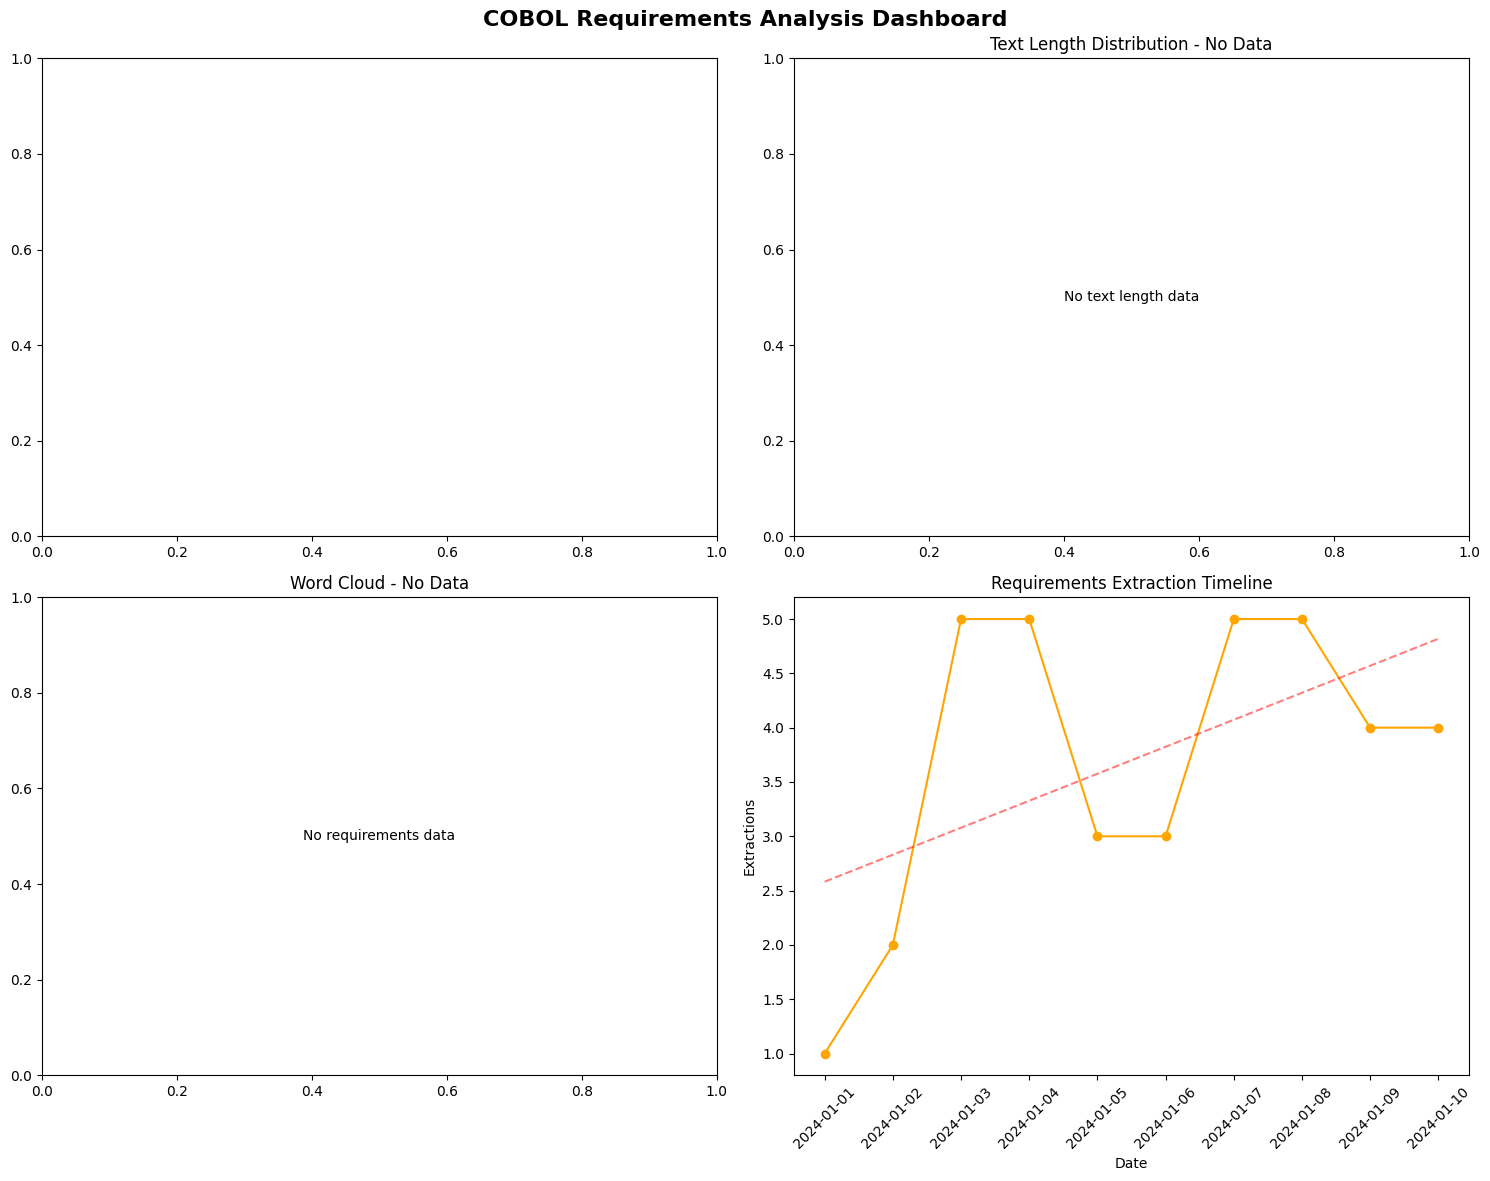


📊 COBOL Requirements Analysis Summary

🎯 NEXT STEPS FOR YOUR COBOL PROJECT:

1. 📁 DATA PREPARATION:
   - Gather your COBOL source files
   - Organize them in a directory structure
   - Ensure proper encoding (UTF-8 recommended)

2. 🔧 CUSTOMIZATION:
   - Modify extraction patterns for your COBOL dialect
   - Adjust similarity thresholds based on your data
   - Add domain-specific business rule patterns

3. 🚀 SCALING:
   - Process files in batches for large codebases
   - Implement parallel processing for faster extraction
   - Set up monitoring for extraction quality

4. 🤖 COPILOT ENHANCEMENT:
   - Use Copilot to improve regex patterns
   - Ask for domain-specific extraction logic
   - Request error handling improvements

5. 📊 ANALYSIS:
   - Build custom dashboards for your requirements
   - Create reports for stakeholders
   - Track requirement evolution over time

✅ COBOL Requirements Analysis Notebook Complete!
💡 Start by running: python cobol_requirements_api.py


In [10]:
# Create visualizations for COBOL requirements analysis
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('COBOL Requirements Analysis Dashboard', fontsize=16, fontweight='bold')

# 1. Requirements Distribution by Program
if extractor:
    try:
        all_reqs = extractor.get_all_requirements()
        if all_reqs:
            program_ids = [req.get('program_id', 'Unknown') for req in all_reqs]
            req_counts = Counter(program_ids)
            
            axes[0, 0].bar(req_counts.keys(), req_counts.values(), color='skyblue')
            axes[0, 0].set_title('Requirements by Program')
            axes[0, 0].set_xlabel('Program ID')
            axes[0, 0].set_ylabel('Count')
            axes[0, 0].tick_params(axis='x', rotation=45)
        else:
            axes[0, 0].text(0.5, 0.5, 'No requirements data', ha='center', va='center')
            axes[0, 0].set_title('Requirements by Program - No Data')
    except Exception as e:
        axes[0, 0].text(0.5, 0.5, f'Error: {e}', ha='center', va='center')
        axes[0, 0].set_title('Requirements by Program - Error')

# 2. Requirement Text Length Distribution
try:
    if extractor and 'all_reqs' in locals() and all_reqs:
        text_lengths = [len(req.get('requirement_text', '')) for req in all_reqs]
        axes[0, 1].hist(text_lengths, bins=10, color='lightgreen', alpha=0.7)
        axes[0, 1].set_title('Requirement Text Length Distribution')
        axes[0, 1].set_xlabel('Text Length (characters)')
        axes[0, 1].set_ylabel('Frequency')
    else:
        axes[0, 1].text(0.5, 0.5, 'No text length data', ha='center', va='center')
        axes[0, 1].set_title('Text Length Distribution - No Data')
except Exception as e:
    axes[0, 1].text(0.5, 0.5, f'Error: {e}', ha='center', va='center')

# 3. Word Cloud of Requirements (if data available)
try:
    if extractor and 'all_reqs' in locals() and all_reqs:
        # Combine all requirement texts
        all_text = ' '.join([req.get('requirement_text', '') for req in all_reqs])
        if all_text.strip():
            # Create word cloud
            wordcloud = WordCloud(width=400, height=300, background_color='white').generate(all_text)
            axes[1, 0].imshow(wordcloud, interpolation='bilinear')
            axes[1, 0].axis('off')
            axes[1, 0].set_title('Requirements Word Cloud')
        else:
            axes[1, 0].text(0.5, 0.5, 'No text for word cloud', ha='center', va='center')
            axes[1, 0].set_title('Word Cloud - No Data')
    else:
        axes[1, 0].text(0.5, 0.5, 'No requirements data', ha='center', va='center')
        axes[1, 0].set_title('Word Cloud - No Data')
except Exception as e:
    axes[1, 0].text(0.5, 0.5, f'Word cloud error: {e}', ha='center', va='center')

# 4. Extraction Timeline (mock data for demonstration)
try:
    # Create sample timeline data
    dates = pd.date_range(start='2024-01-01', periods=10, freq='D')
    extractions = np.random.poisson(3, 10)  # Mock extraction counts
    
    axes[1, 1].plot(dates, extractions, marker='o', color='orange')
    axes[1, 1].set_title('Requirements Extraction Timeline')
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].set_ylabel('Extractions')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    # Add trend line
    z = np.polyfit(range(len(dates)), extractions, 1)
    p = np.poly1d(z)
    axes[1, 1].plot(dates, p(range(len(dates))), "--", alpha=0.5, color='red')
    
except Exception as e:
    axes[1, 1].text(0.5, 0.5, f'Timeline error: {e}', ha='center', va='center')

plt.tight_layout()
plt.show()

# Summary Statistics
print("\n📊 COBOL Requirements Analysis Summary")
print("=" * 45)

if extractor:
    try:
        stats = {
            'total_programs': len(all_reqs) if 'all_reqs' in locals() and all_reqs else 0,
            'avg_text_length': np.mean(text_lengths) if 'text_lengths' in locals() and text_lengths else 0,
            'vector_db_status': 'Connected' if extractor.client else 'Disconnected'
        }
        
        for key, value in stats.items():
            print(f"📈 {key.replace('_', ' ').title()}: {value}")
            
    except Exception as e:
        print(f"❌ Error generating statistics: {e}")

print(f"""
🎯 NEXT STEPS FOR YOUR COBOL PROJECT:

1. 📁 DATA PREPARATION:
   - Gather your COBOL source files
   - Organize them in a directory structure
   - Ensure proper encoding (UTF-8 recommended)

2. 🔧 CUSTOMIZATION:
   - Modify extraction patterns for your COBOL dialect
   - Adjust similarity thresholds based on your data
   - Add domain-specific business rule patterns

3. 🚀 SCALING:
   - Process files in batches for large codebases
   - Implement parallel processing for faster extraction
   - Set up monitoring for extraction quality

4. 🤖 COPILOT ENHANCEMENT:
   - Use Copilot to improve regex patterns
   - Ask for domain-specific extraction logic
   - Request error handling improvements

5. 📊 ANALYSIS:
   - Build custom dashboards for your requirements
   - Create reports for stakeholders
   - Track requirement evolution over time
""")

print("✅ COBOL Requirements Analysis Notebook Complete!")
print("💡 Start by running: python cobol_requirements_api.py")